# Train NER
This notebook improves the NER training pipeline from Kaggle competition with higher quality training data. The first goal is to generate a few hundred positive and negative examples of `Dataset` references for model training and evaluation. The second goal is to train a generalizable model that can detect `Dataset` entities. Load notebook with GPU if Step 3; CPU if Steps 1-2 or 4.

1. [x] Prepare training data for annotation
2. [x] Import annotated training data
3. [ ] Train and save NER model
4. [ ] Apply NER model

## 1. Prepare training data for annotation
This step takes advantage of existing labels to ensure that the samples are relatively balanced
- generate UUIDs for papers
- link paper full text to labels
- tokenize sentences
- generate sentence numbers
- link `dataset_label` to sentences from paper
- add `source` 
- concatenate and shuffle Kaggle and ICPSR Bibliography data

In [2]:
import pandas as pd
import numpy as np
import re
import ftfy
import os
import glob
import json
import random
import uuid
from tqdm import tqdm

import nltk
from nltk.tokenize import sent_tokenize
from sklearn.utils import resample

In [3]:
def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

In [4]:
DIR = '/nfs/turbo/hrg/bib/icpsr-we-have-the-data/'

## Coleridge Kaggle papers
Sample 200/14316 papers at random; set seed for reproducibility. Crosstab gives a sense of the diversity of dataset labels included in the sample.

In [4]:
%%time

df_coleridge = pd.read_csv(DIR + 'coleridge_train.csv',low_memory=False)

df_coleridge_sample = df_coleridge.sample(n=200, random_state=1)

df_coleridge_papers = pd.DataFrame()
for idx, row in tqdm(df_coleridge_sample.iterrows()): 
    paper = DIR + 'coleridge_papers/' + row.Id + ".json"
    paper_data = pd.read_json(paper)
    paper_data.insert(0,'Id', paper.split('/')[-1].split('.')[0])
    paper_data['pub_title'] = row.pub_title
    paper_data['dataset_title'] = row.dataset_title
    paper_data['dataset_label'] = row.dataset_label
    df_coleridge_papers = pd.concat([df_coleridge_papers, paper_data])

coleridge_sentences = []

for row in tqdm(df_coleridge_papers.itertuples()):
    for sent in sent_tokenize(row[3]):
        sec_idx = sent_tokenize(row[3]).index(sent)
        source = "coleridge"
        cleaned_sent = clean_text(sent)
        cleaned_label = clean_text(row[6])
        a = re.search(cleaned_label, cleaned_sent)
        if  a != None:
            refs_dataset = True
        else:
            refs_dataset = False
        coleridge_sentences.append((row[1], row[4], row[2], source, sec_idx, sent, row[5], row[6], refs_dataset))

df_coleridge_sentences = pd.DataFrame(coleridge_sentences, columns=['paper_id', 'paper_title', 'paper_section', 'source', 'sentence_id', 'sentence_text', 'dataset_title', 'dataset_label', 'refs_dataset'])

df_coleridge_sentences['dataset_title'] = df_coleridge_sentences.apply(lambda x: "None" if x['refs_dataset']==False else x['dataset_title'], axis=1)
df_coleridge_sentences['dataset_label'] = df_coleridge_sentences.apply(lambda x: "None" if x['refs_dataset']==False else x['dataset_label'], axis=1)

df_coleridge_majority = df_coleridge_sentences[df_coleridge_sentences.refs_dataset==False]
df_coleridge_minority = df_coleridge_sentences[df_coleridge_sentences.refs_dataset==True]

df_coleridge_downsampled = resample(df_coleridge_majority, replace=False, n_samples=len(df_coleridge_minority), random_state=1)

df_train_coleridge = pd.concat([df_coleridge_downsampled, df_coleridge_minority])

pd.crosstab([df_train_coleridge.dataset_label], df_train_coleridge.refs_dataset)

200it [00:01, 108.28it/s]
3736it [00:58, 63.52it/s] 


CPU times: user 1min, sys: 248 ms, total: 1min
Wall time: 1min 1s


refs_dataset,False,True
dataset_label,,
ADNI,0,328
ANSS Comprehensive Catalog,0,1
Agricultural Resource Management Survey,0,8
Alzheimer's Disease Neuroimaging Initiative (ADNI),0,22
Alzheimers Disease Neuroimaging Initiative,0,2
Baccalaureate and Beyond,0,3
Baltimore Longitudinal Study of Aging,0,16
Baltimore Longitudinal Study of Aging (BLSA),0,6
Beginning Postsecondary Student,0,2


## ICPSR Bibliography Data
Sample 200/1836 papers at random; set seed for reproducibility. Crosstab gives a sense of the diversity of studies and series labels included in the sample.

In [5]:
%%time

train_files = glob.glob(DIR + 'icpsr_papers/*.json')

df_train_pubs = pd.DataFrame()
for train_file in train_files: 
    with open(train_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_train_pubs = pd.concat([df_train_pubs, file_data])

df_train_pubs['test_name'] = df_train_pubs.paper_id.apply(alphanum)
df_train_pubs['paper_title'] = df_train_pubs.paper_id
df_train_pubs.loc[:, "uuid"] = 1
df_train_pubs.loc[:, "uuid"] = df_train_pubs.groupby("paper_title").uuid.transform(lambda g: uuid.uuid4())

grouped_pubs = df_train_pubs.groupby(['uuid', 'paper_title', 'test_name', 'section'], as_index = False).agg({'text': ' '.join})

df_icpsr = pd.read_excel(DIR + 'icpsr_train.xlsx', encoding="UTF-8-SIG")
df_icpsr = df_icpsr.dropna(subset=['doi', 'notes'])

df_icpsr['test_name'] = df_icpsr.title.apply(alphanum)
df_icpsr['notes'] = df_icpsr.notes.apply(ftfy.fix_text)
df_icpsr['notes_has_quote'] = df_icpsr['notes'].str.contains(r'"(.+?)"')

df_icpsr_quotes = df_icpsr[df_icpsr['notes_has_quote']==True]

paper_ids = df_train_pubs['test_name'].tolist()
boolean_series = df_icpsr_quotes.test_name.isin(paper_ids)
filtered_df = df_icpsr_quotes[boolean_series]

df_icpsr_sample = filtered_df.sample(n=200, random_state=1)
sample_ids = df_icpsr_sample['test_name'].tolist()

matching_series = grouped_pubs.test_name.isin(sample_ids)
filtered_pubs = grouped_pubs[matching_series]

df_icpsr_sentences = []

for row in tqdm(filtered_pubs.itertuples()):
    for sent in sent_tokenize(row[5]):
        sec_idx = sent_tokenize(row[5]).index(sent)
        source = "icpsr"
        df_icpsr_sentences.append((row[1], row[2], row[4], source, sec_idx, sent))

df_icpsr_sents = pd.DataFrame(df_icpsr_sentences, columns=['paper_id', 'paper_title', 'paper_section', 'source', 'sentence_id', 'sentence_text'])
df_train_icpsr_sents = df_icpsr_sents.sample(frac=0.1, random_state=1)

df_icpsr_sents = pd.DataFrame(df_icpsr_sentences, columns=['paper_id', 'paper_title', 'paper_section', 'source', 'sentence_id', 'sentence_text'])
df_train_icpsr_sents = df_icpsr_sents.sample(frac=0.5, random_state=1)

studies_df = pd.read_csv(DIR + 'icpsr_study_name_aliases.csv')

all_titles = studies_df.apply(lambda x: list([x['NAME'],
                                              x['SERIES_TITLE'],
                                              x['ALTTITLE1'],
                                              x['ALTTITLE2'],
                                              x['ALTTITLE3'],
                                              x['ALTTITLE4'],
                                              x['ALTTITLE5'],
                                              x['ALTTITLE6'],
                                              x['ALTTITLE7']]),axis=1)

flat_titles = all_titles.apply(pd.Series).stack().reset_index(drop = True)
unique_titles = flat_titles.dropna().unique().tolist()
clean_titles = [clean_text2(item) for item in unique_titles]

studies_pattern = '|'.join(clean_titles)

df_train_icpsr_sents['clean_sentence'] = df_train_icpsr_sents['sentence_text'].apply(clean_text2)

df_train_icpsr_sents['dataset_label'] = df_train_icpsr_sents['clean_sentence'].apply(lambda x: extract_pat(search_str=x, search_list=studies_pattern))
df_train_icpsr_sents['refs_dataset'] = df_train_icpsr_sents.apply(lambda x: False if x['dataset_label']=='None' else True, axis=1)

df_icpsr_majority = df_train_icpsr_sents[df_train_icpsr_sents.refs_dataset==False]
df_icpsr_minority = df_train_icpsr_sents[df_train_icpsr_sents.refs_dataset==True]

df_icpsr_downsampled = resample(df_icpsr_majority, replace=False, n_samples=len(df_icpsr_minority), random_state=1)

df_train_icpsr = pd.concat([df_icpsr_downsampled, df_icpsr_minority])

pd.crosstab([df_train_icpsr.dataset_label], df_train_icpsr.refs_dataset)

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2730it [00:53, 50.80it/s]


CPU times: user 5min 57s, sys: 5.9 s, total: 6min 3s
Wall time: 6min 37s


refs_dataset,False,True
dataset_label,,
1955 GAF,0,1
1960 GAF,0,2
1965 NFS,0,1
1970 NFS,0,6
AAU Campus Climate Survey on Sexual Assault and Sexual Misconduct,0,3
Bureau of Labor Statistics,0,8
CBP,0,1
CLHLS,0,11
ECLS,0,53


## Concatenate, sample, and export training data for annotation
In summary, we sampled sentences from 200 Coleridge papers and 200 ICPSR papers for review and annotation.

In [6]:
df_train_coleridge = df_train_coleridge.drop(columns=['dataset_title', 'dataset_label', 'refs_dataset'])
df_train_icpsr = df_train_icpsr.drop(columns=['clean_sentence', 'dataset_label', 'refs_dataset'])

frames = [df_train_coleridge, df_train_icpsr]
df_annotation = pd.concat(frames)
df_annotation

,paper_id,paper_title,paper_section,source,sentence_id,sentence_text
1310,22f04ef5-6bf1-4221-ae9c-b60ee9847590,The Effect of Switching Field of Study Betwee...,Results,coleridge,9,After examining the effect of switching field ...
36818,c5991999-d7bf-4dba-a6b5-d961a2540db2,Inequalities at the Starting Gate: Cognitive a...,Policy implications: Economic and social policies,coleridge,11,These programs help ensure that children do no...
33484,f1bcf379-29a5-41d5-bf08-6087560be3ac,"Education and Training in the Social, Behavio...",Special Attention to Inclusion of the SBE Scie...,coleridge,18,Program Directors in EHR and SBE are at the fo...
27080,38c10b03-3356-404e-a321-d8301cd0ec4c,Blood-based protein predictors of dementia sev...,Clinical variables,coleridge,6,Categorical fluency (animals) [23] is a test o...
4900,c36d60e3-05f3-4da5-8e85-1e31767d0cf5,Dominant Role of Subtropical Pacific Warming i...,a. Observed analysis for the extremely active ...,coleridge,28,"Moreover, mean midlevel relative humidity was ..."
...,...,...,...,...,...,...
21429,70f4c55e-347a-433a-a89b-335163191505,Do Police Body-Worn Cameras Reduce Citizen Fat...,Sample,icpsr,13,We relied on specific questions within the LEM...
38767,cc9f13cb-1a5b-4b07-a097-fce2188c355b,The stability of elementary school contexts fr...,Discussion,icpsr,5,What is perhaps most striking from the descrip...
9902,3f4495ac-1734-4610-9754-bab0d926a516,Climate change and victimization risk: A disag...,Discussion,icpsr,6,"This certainly creates some issues, including ..."
1351,0a2b8819-7258-4b60-b999-ed73621380bb,THE EFFECT OF SOCIAL CONNECTEDNESS ON CRIME: E...,"A. Data on Crime, Social Connectedness, and Co...",icpsr,2,UCR data contain monthly counts of the number ...


In [8]:
df_annotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 1310 to 5052
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   paper_id       2056 non-null   object
 1   paper_title    2056 non-null   object
 2   paper_section  2056 non-null   object
 3   source         2056 non-null   object
 4   sentence_id    2056 non-null   int64 
 5   sentence_text  2056 non-null   object
dtypes: int64(1), object(5)
memory usage: 112.4+ KB


In [9]:
df_annotation.source.value_counts()

coleridge    1230
icpsr         826
Name: source, dtype: int64

In [11]:
df_annotation.to_csv('/nfs/turbo/hrg/bib/icpsr-we-have-the-data/train_ann_papers_400_sents_2056.csv', index=0)

## 2. Import annotated training data
Keep only validated records

In [5]:
df_valid = pd.read_csv(DIR + 'train_labeled_papers_400_sents_2056.csv').dropna(subset=['labeler_1'])
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 2055
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   paper_id                    402 non-null    object 
 1   paper_title                 402 non-null    object 
 2   paper_section               390 non-null    object 
 3   source                      402 non-null    object 
 4   sentence_id                 402 non-null    int64  
 5   sentence_text               402 non-null    object 
 6   text_referencing_dataset_1  402 non-null    object 
 7   intent_1                    211 non-null    object 
 8   labeler_1                   402 non-null    object 
 9   notes_1                     16 non-null     object 
 10  contains_dataset_1          402 non-null    object 
 11  text_referencing_dataset_2  0 non-null      float64
 12  intent_2                    0 non-null      float64
 13  labeler_2                   0 non-

How many positive and negative examples come from each `source` in the training data?

In [6]:
df_valid.contains_dataset_1.value_counts()

TRUE     213
FALSE    189
Name: contains_dataset_1, dtype: int64

In [7]:
pd.crosstab(df_valid.source, df_valid.contains_dataset_1)

contains_dataset_1,FALSE,TRUE
source,,
coleridge,184,17
icpsr,5,196


What is the distribution of citation `intent` in the sample of dataset citations?

In [8]:
df_valid.intent_1.value_counts()

Background    88
Uses          75
Compares      31
Motivates     10
Validation     4
Future         3
Name: intent_1, dtype: int64

In [9]:
df_valid

,paper_id,paper_title,paper_section,source,sentence_id,sentence_text,text_referencing_dataset_1,intent_1,labeler_1,notes_1,contains_dataset_1,text_referencing_dataset_2,intent_2,labeler_2,notes_2,contains_dataset_2,labelers_agree
0,22f04ef5-6bf1-4221-ae9c-b60ee9847590,The Effect of Switching Field of Study Between...,Results,coleridge,9,After examining the effect of switching field ...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
1,c5991999-d7bf-4dba-a6b5-d961a2540db2,Inequalities at the Starting Gate: Cognitive a...,Policy implications: Economic and social policies,coleridge,11,These programs help ensure that children do no...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
2,f1bcf379-29a5-41d5-bf08-6087560be3ac,"Education and Training in the Social, Behavio...",Special Attention to Inclusion of the SBE Scie...,coleridge,18,Program Directors in EHR and SBE are at the fo...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
3,38c10b03-3356-404e-a321-d8301cd0ec4c,Blood-based protein predictors of dementia sev...,Clinical variables,coleridge,6,Categorical fluency (animals) [23] is a test o...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
4,c36d60e3-05f3-4da5-8e85-1e31767d0cf5,Dominant Role of Subtropical Pacific Warming i...,a. Observed analysis for the extremely active ...,coleridge,28,"Moreover, mean midlevel relative humidity was ...",none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,70f4c55e-347a-433a-a89b-335163191505,Do Police Body-Worn Cameras Reduce Citizen Fat...,Sample,icpsr,13,We relied on specific questions within the LEM...,LEMAS-BWCS survey,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2052,cc9f13cb-1a5b-4b07-a097-fce2188c355b,The stability of elementary school contexts fr...,Discussion,icpsr,5,What is perhaps most striking from the descrip...,ECLS-K,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2053,3f4495ac-1734-4610-9754-bab0d926a516,Climate change and victimization risk: A disag...,Discussion,icpsr,6,"This certainly creates some issues, including ...",UCR,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2054,0a2b8819-7258-4b60-b999-ed73621380bb,THE EFFECT OF SOCIAL CONNECTEDNESS ON CRIME: E...,"A. Data on Crime, Social Connectedness, and Co...",icpsr,2,UCR data contain monthly counts of the number ...,UCR,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False


Explode rows with more than 1 dataset reference per sentence

In [10]:
df_explode = df_valid.assign(text_referencing_dataset_1=df_valid['text_referencing_dataset_1'].str.split(';')).explode('text_referencing_dataset_1')
df_explode

,paper_id,paper_title,paper_section,source,sentence_id,sentence_text,text_referencing_dataset_1,intent_1,labeler_1,notes_1,contains_dataset_1,text_referencing_dataset_2,intent_2,labeler_2,notes_2,contains_dataset_2,labelers_agree
0,22f04ef5-6bf1-4221-ae9c-b60ee9847590,The Effect of Switching Field of Study Between...,Results,coleridge,9,After examining the effect of switching field ...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
1,c5991999-d7bf-4dba-a6b5-d961a2540db2,Inequalities at the Starting Gate: Cognitive a...,Policy implications: Economic and social policies,coleridge,11,These programs help ensure that children do no...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
2,f1bcf379-29a5-41d5-bf08-6087560be3ac,"Education and Training in the Social, Behavio...",Special Attention to Inclusion of the SBE Scie...,coleridge,18,Program Directors in EHR and SBE are at the fo...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
3,38c10b03-3356-404e-a321-d8301cd0ec4c,Blood-based protein predictors of dementia sev...,Clinical variables,coleridge,6,Categorical fluency (animals) [23] is a test o...,none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
4,c36d60e3-05f3-4da5-8e85-1e31767d0cf5,Dominant Role of Subtropical Pacific Warming i...,a. Observed analysis for the extremely active ...,coleridge,28,"Moreover, mean midlevel relative humidity was ...",none,NaN,Sara,NaN,FALSE,NaN,NaN,NaN,NaN,not complete,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,70f4c55e-347a-433a-a89b-335163191505,Do Police Body-Worn Cameras Reduce Citizen Fat...,Sample,icpsr,13,We relied on specific questions within the LEM...,LEMAS-BWCS survey,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2052,cc9f13cb-1a5b-4b07-a097-fce2188c355b,The stability of elementary school contexts fr...,Discussion,icpsr,5,What is perhaps most striking from the descrip...,ECLS-K,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2053,3f4495ac-1734-4610-9754-bab0d926a516,Climate change and victimization risk: A disag...,Discussion,icpsr,6,"This certainly creates some issues, including ...",UCR,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False
2054,0a2b8819-7258-4b60-b999-ed73621380bb,THE EFFECT OF SOCIAL CONNECTEDNESS ON CRIME: E...,"A. Data on Crime, Social Connectedness, and Co...",icpsr,2,UCR data contain monthly counts of the number ...,UCR,Uses,Sara,NaN,TRUE,NaN,NaN,NaN,NaN,not complete,False


How many unique dataset references are labeled?

In [11]:
df_explode.text_referencing_dataset_1.value_counts()

none                                    189
NCVS                                     30
NHATS                                    11
UCR                                       9
HSIS                                      8
                                       ... 
Medicare Carrier files                    1
 National Survey of MIDUS                 1
ECLS-K dataset                            1
 NIBRS 1997-2014                          1
2002 Workplace Risk Supplement (WRS)      1
Name: text_referencing_dataset_1, Length: 168, dtype: int64

Get entity spans for positive and negative examples

In [13]:
df_explode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 0 to 2055
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   paper_id                    479 non-null    object 
 1   paper_title                 479 non-null    object 
 2   paper_section               466 non-null    object 
 3   source                      479 non-null    object 
 4   sentence_id                 479 non-null    int64  
 5   sentence_text               479 non-null    object 
 6   text_referencing_dataset_1  479 non-null    object 
 7   intent_1                    288 non-null    object 
 8   labeler_1                   479 non-null    object 
 9   notes_1                     19 non-null     object 
 10  contains_dataset_1          479 non-null    object 
 11  text_referencing_dataset_2  0 non-null      float64
 12  intent_2                    0 non-null      float64
 13  labeler_2                   0 non-

In [14]:
%%time

POSITIVE_DATA = []
NEGATIVE_DATA = []

for idx, row in tqdm(df_explode.iterrows()):
    label = row.text_referencing_dataset_1
    sentence = row.sentence_text
    label2 = clean_text(label)
    sentence2 = clean_text(sentence)
    a = re.search(label2, sentence2)
    if row.contains_dataset_1 == 'FALSE':
        NEGATIVE_DATA.append((clean_text2(sentence),{"entities":[(0,0,"DATASET")]}))
    else:
        POSITIVE_DATA.append((clean_text2(sentence),{"entities":[(a.span()[0],a.span()[1],"DATASET")]}))

479it [00:00, 5902.63it/s]

CPU times: user 81.8 ms, sys: 1.92 ms, total: 83.7 ms
Wall time: 82.6 ms


In [15]:
POSITIVE_DATA[:10]

[('3 This study is based on data from the 2007 ARMS Phase III survey which used a probability based stratifi ed multiframe sample to provide detailed information on farm businesses and their operators from 18 907 usable questionnaires Banker 2007 ',
  {'entities': [(39, 65, 'DATASET')]}),
 ('According to the regression analysis there exists a high correlation between the NASS and the Ag Census databases ',
  {'entities': [(81, 85, 'DATASET')]}),
 ('According to the regression analysis there exists a high correlation between the NASS and the Ag Census databases ',
  {'entities': [(93, 113, 'DATASET')]}),
 ('Because state test score gains have not always been reflected in gains on other tests such as the National Assessment of Educational Progress NAEP or international assessments others have suggested that state test score gains in the NCLB era may be illusory Koretz 2008 ',
  {'entities': [(98, 147, 'DATASET')]}),
 ('As far as possible test administration was in keeping with the BAS in

In [16]:
len(POSITIVE_DATA)

290

In [17]:
len(NEGATIVE_DATA)

189

Balance classes by setting negative sample equal to length of positive sample
- set seed to ensure selection is reproducible

In [18]:
random.seed(1)
POS_SAMPLE = random.choices(POSITIVE_DATA, k=len(NEGATIVE_DATA))
POS_SAMPLE[:10]

[('The main dependent variable Use of Force UOF was drawn from the 2013 LEMAS survey ',
  {'entities': [(64, 81, 'DATASET')]}),
 ('This NAEP HSLS overlap sample enables the estimation of relationships between NAEP achievement and variables collected in HSLS 09 including the mathematics motivation and transcript data that are the focus of this study ',
  {'entities': [(5, 14, 'DATASET')]}),
 ('Unlike the CDC and MTF studies The Growing up Today GUT Study Field et al 2005 places its steroid question last in a series of seven questions regarding substances typically used for muscle gains fat loss or athletic performance Fig ',
  {'entities': [(18, 22, 'DATASET')]}),
 ('In addition our data are heavily weighted toward Head Start centers three of the data sets include only Head Start programs HSIS and FACES and the other two include a combination of center based preschool settings including state pre K and Head Start ',
  {'entities': [(124, 128, 'DATASET')]}),
 ('Though not directly compar

Merge and shuffle positive and negative examples

In [19]:
TRAIN_DATA = np.array(NEGATIVE_DATA + POS_SAMPLE)
np.random.shuffle(TRAIN_DATA)
len(TRAIN_DATA)

378

In [20]:
import spacy
from spacy.tokens import DocBin
from spacy import displacy

In [21]:
print(spacy.__version__)
print(spacy.require_gpu())

3.1.1
True


Initialize simple pre-trained English model and a docbin object for storing entity spans

In [22]:
nlp = spacy.blank("en")
db = DocBin()

/home/slafia/.local/lib/python3.8/site-packages/spacy/util.py:1525: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Format validated entity spans from training data to DocBin object

In [23]:
for text, annot in tqdm(TRAIN_DATA):
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in annot["entities"]:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            pass
        else:
            ents.append(span)
    doc.ents = ents
    db.add(doc)

db.to_disk("./train.spacy")

100%|██████████| 378/378 [00:00<00:00, 1488.85it/s]


Copy default base configuration file (which stores all of the training settings) to initialize model

In [24]:
!cp "./base_config.cfg" ./

cp: ‘./base_config.cfg’ and ‘./base_config.cfg’ are the same file


Initialize base config with default training settings

In [25]:
!python -m spacy init fill-config base_config.cfg config.cfg 

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## 3. Train and save NER model

In [26]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy --gpu-id 0 

ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2021-09-13 18:06:22,517] [INFO] Set up nlp object from config
[2021-09-13 18:06:22,526] [INFO] Pipeline: ['transformer', 'ner']
[2021-09-13 18:06:22,529] [INFO] Created vocabulary
[2021-09-13 18:06:22,529] [INFO] Finished initializing nlp object
[2021-09-13 18:07:09,775] [INFO] Initialized pipeline components: ['transformer', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'ner']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  -------------  --------  ------  ------  ------  ------
  0       0        5170.71    381.60    0.23    0.13    1.06    0.00
 28     200      111993.91  36577.47   87.15   83.17   91.53    0.87
 57     400         828.38   1494.15   89.92   92.70   87.30    0.90
 85     600         677.41   1313.32   91.21   94.86   87.83  

## 4. Apply NER model
Extract `Dataset` entities as predictions and compare string to label

Load best performing model

In [89]:
from thinc.api import set_gpu_allocator, require_gpu
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [90]:
spacy.prefer_gpu()
custom_ner_model = spacy.load("../notebooks/output/model-best/")

Load unlabeled sentences in training data to make predictions

In [94]:
df_predict = pd.read_csv(DIR + 'train_labeled_papers_400_sents_2056.csv')
df_predict = df_predict[~((df_predict['labeler_1']=="Sara"))]
df_predict['sentence_text'] = df_predict['sentence_text'].astype(str)

df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 201 to 1854
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   paper_id                    1654 non-null   object 
 1   paper_title                 1654 non-null   object 
 2   paper_section               1595 non-null   object 
 3   source                      1654 non-null   object 
 4   sentence_id                 1654 non-null   int64  
 5   sentence_text               1654 non-null   object 
 6   text_referencing_dataset_1  0 non-null      object 
 7   intent_1                    0 non-null      object 
 8   labeler_1                   0 non-null      object 
 9   notes_1                     0 non-null      object 
 10  contains_dataset_1          1654 non-null   object 
 11  text_referencing_dataset_2  0 non-null      float64
 12  intent_2                    0 non-null      float64
 13  labeler_2                   0 n

Display predictions for sentences not in training data

In [93]:
test_sample = df_predict.sample(n=20, random_state=1)

for index, row in test_sample.iterrows():
    sentence = clean_text2(row.sentence_text)
    doc = custom_ner_model(sentence)
    if len(doc.ents) > 0:
        displacy.render(doc, style="ent", jupyter=True)

Apply custom_ner_model to `notes` and store predictions in a new column

In [95]:
def extract_ents(text):
    """Extract named entities, and beginning, middle and end idx 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
    
#     return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]
#     return [(ent.text, ent.label_) for ent in custom_ner_model(text).ents]

    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
    df_predict['dataset_prediction'] = df_predict['sentence_text'].apply(extract_ents)

Summarize the predicted Dataset entities
* once labels are validated, add a column for true labels, then calculate string similarity across columns with Jaccard

In [96]:
%%time

predict_ents(df_predict)

CPU times: user 21.5 s, sys: 21.2 ms, total: 21.5 s
Wall time: 21.6 s


,paper_id,paper_title,paper_section,source,sentence_id,sentence_text,text_referencing_dataset_1,intent_1,labeler_1,notes_1,contains_dataset_1,text_referencing_dataset_2,intent_2,labeler_2,notes_2,contains_dataset_2,labelers_agree,dataset_prediction
201,89e0f900-cd7a-4bd3-b8c7-efd4e7fc15da,National Education Longitudinal Study of 1988....,4,coleridge,1,This subset was the schools selected via their...,NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,None
202,64445ab3-6134-49fa-a2b5-87952c48d526,SARS-CoV-2 genetic variations associated with ...,31,coleridge,7,Although the case-46 fatality ratio of SARS-Co...,NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,SARS MERS
203,6042468d-90a4-4049-8dcc-64145e7cec81,On statistical tests of functional connectome ...,Alternative justifications of the permutation ...,coleridge,10,"First, note that our permuted statistic satisf...",NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,None
204,5dc196d2-9ebd-4e09-82ff-b90e6c70167e,Early Labor Force Experiences and Debt Burden....,Clerical,coleridge,1,"See entry for ""Raceethnicity"" in Part I for a ...",NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,None
205,f89f5be3-8e71-462b-840e-4f90b1ac5180,Prevention and the Child Protection System,Looking Ahead: Suggestions for Further Researc...,coleridge,9,"But beyond that, researchers have much more to...",NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,3da4190e-6376-4ceb-b815-bdf3c712c2b1,"Race, representation, and assets forfeiture",Control variables,icpsr,2,The first category captures basic departmental...,NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,LEMAS
1851,d0685120-b106-4ae5-bed2-922df4780cae,Linking Amygdala Persistence to Real-World Emo...,Introduction,icpsr,24,We analyzed a Midlife in the United States (MI...,NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,Midlife in the United States MIDUS
1852,f6d0adbd-cf3a-4a8d-a6f8-db1869867a18,The relationship between teachers' teaching se...,Hypotheses,icpsr,0,Based on previous literature and research on t...,NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,Early Childhood Longitudinal Study Kindergart...
1853,3f4495ac-1734-4610-9754-bab0d926a516,Climate change and victimization risk: A disag...,Data and methods,icpsr,13,"2 For the purposes of the current study, one i...",NaN,NaN,NaN,NaN,not complete,NaN,NaN,NaN,NaN,NaN,NaN,NCVS


Summarize number of times particular `Dataset` entities are detected in the ICPSR Bibliography `notes` sample

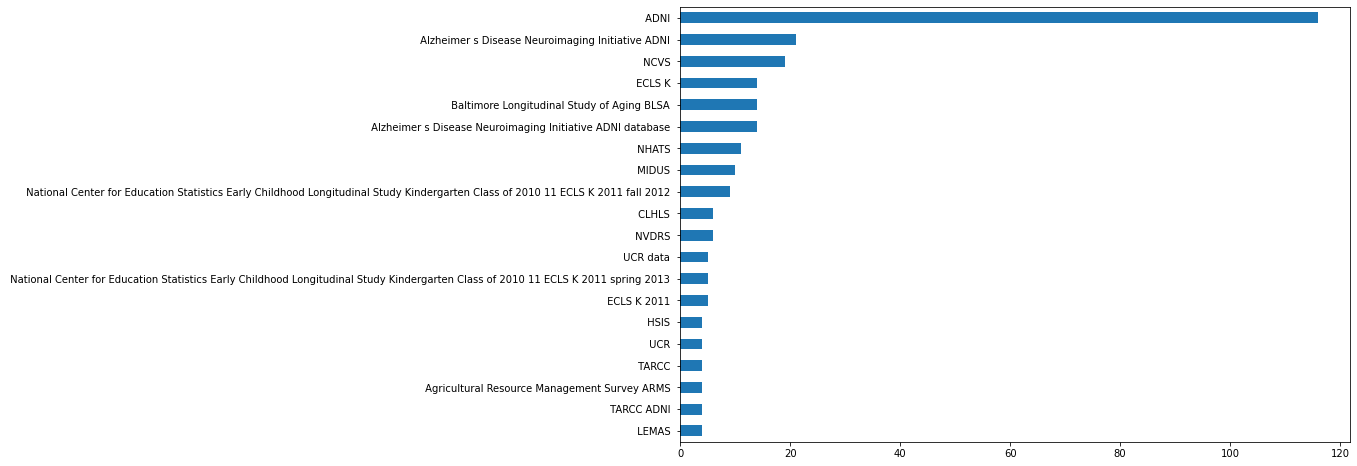

In [99]:
pred_datasets = df_predict['dataset_prediction'].value_counts().sort_values()
most_mentioned = pred_datasets.nlargest(20).sort_values()
most_mentioned.plot(kind='barh',figsize=(12,8))

Add a new column for overlap between `dataset_label` and ` dataset_prediction` based on Jaccard similarity

In [97]:
# df_icpsr['dataset_label'] = df_icpsr['dataset_label'].astype(str)
# df_icpsr['dataset_prediction'] = df_icpsr['dataset_prediction'].astype(str)

# dataset_jaccard = []
# for index, row in df_icpsr.iterrows():
#     dataset_jaccard.append(jaccard(row['dataset_label'], row['dataset_prediction']))
    
# df_icpsr['dataset_jaccard'] = dataset_jaccard

# df_compare = df_icpsr[['doi', 'notes', 'series_nums', 'stud_nums', 'dataset_label','dataset_prediction','dataset_jaccard']]
# df_compare.head(40)

What does the distribution of Jaccard scores look like?
- we would like a model that captures more than 0.5 of all possible entities per document
- interpretation: we need to retrain model to include more examples and reassess performance

In [98]:
# df_compare['dataset_jaccard'].plot.hist(bins=12, alpha=0.5, figsize=(12,10)) 